# Building a Bigram Language Model from Scratch
---

This is an extended version of Andrej Karpathy's notebook in addition to his [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on bigram language models.

Adapted by: 

Prof. Dr.-Ing. Antje Muntzinger, University of Applied Sciences Stuttgart

antje.muntzinger@hft-stuttgart.de

---


We'll construct a bigram language model from scratch. 
The model will be trained on a text file containing names and will be able to generate new names based on what it has learned. So if you are expecting a baby and looking for some extraordinary new name, you might get some inspiration here :)


**NOTE:** You may answer in English or German.

# Table of Contents

[1. Loading the Data](#1.-loading-the-data)

[2. Preprocessing the Data](#2.-preprocessing-the-data)

[3. Bigram Counts as PyTorch Tensor](#3.-Bigram-Counts-as-PyTorch-Tensor)

[4. Sampling New Characters](#4.-sampling-new-characters)

[5. Broadcasting](#5.-broadcasting)

[6. Generating New Names](#6.-generating-new-names)

[7. Evaluating the Model](#7.-evaluating-the-model)

[8. The Neural Network Approach](#8.-the-neural-network-approach)

[9. The First Neuron](#9.-The-First-Neuron)

[10. Creating 27 Neurons](#10.-Creating-27-Neurons)

[11. Summary (so far)](#11.-Summary-(so-far))

[12. Optimization](#12.-Optimization)

[13. Optimizing over the Whole Dataset](#13.-Optimizing-over-the-Whole-Dataset)

[14. Sampling from the Neural Net](#14.-Sampling-from-the-Neural-Net)

[15. Conclusion](#15.-Conclusion)

## 1. Loading and Preprocessing the Data

First, we read the names from the text file and save them in a list.

In [1]:
words = open('names.txt', 'r').read().splitlines()

**TODO:** 1) Print the first 10 names. Find out the number of names contained in the dataset as well as the shortest and longest name. **(2 points)**

In [2]:
# YOUR CODE GOES HERE
print('First 10 names:', words[:10])
print('Number of names:', len(words))
print('Shortest name:', min(words, key=len))
print('Longest name:', max(words, key=len))

First 10 names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Number of names: 32033
Shortest name: an
Longest name: muhammadibrahim


Note that in one example name like "isabella", a lot of information is contained. For example:
- "i" is likely to be the first character of a name
- "s" is likely to follow after an "i"
- "a" is likely to follow after "is"
- ...
- after "isabella", the name is likely to end.

Here we are going to create a **bigram** language model, which means we only use the single previous character to predict the next. For example, we use "s" (not "is") to predict "a" in "isabella" and forget that we have a lot more information.

## 2. Preprocessing the Data

First, we introduce two special characters, `<S>` for "start" and `<E>` for "end". Then we zip two consecutive characters and print them: 

In [3]:
b = {} # dictionary to store bigram counts
for w in words: # print bigrams
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]): # zip(['a', 'b', 'c'], ['b', 'c', 'd']) -> [('a', 'b'), ('b', 'c'), ('c', 'd')]
        bigram = (ch1, ch2)
        # count how many times bigram appears
        b[bigram] = b.get(bigram, 0) + 1 # b.get(bigram, 0) returns b[bigram] if bigram is in b, otherwise 0
        print(ch1, ch2, b[bigram])

<S> e 1
e m 1
m m 1
m a 1
a <E> 1
<S> o 1
o l 1
l i 1
i v 1
v i 1
i a 1
a <E> 2
<S> a 1
a v 1
v a 1
a <E> 3
<S> i 1
i s 1
s a 1
a b 1
b e 1
e l 1
l l 1
l a 1
a <E> 4
<S> s 1
s o 1
o p 1
p h 1
h i 1
i a 2
a <E> 5
<S> c 1
c h 1
h a 1
a r 1
r l 1
l o 1
o t 1
t t 1
t e 1
e <E> 1
<S> m 1
m i 1
i a 3
a <E> 6
<S> a 2
a m 1
m e 1
e l 2
l i 2
i a 4
a <E> 7
<S> h 1
h a 2
a r 2
r p 1
p e 1
e r 1
r <E> 1
<S> e 2
e v 1
v e 1
e l 3
l y 1
y n 1
n <E> 1
<S> a 3
a b 2
b i 1
i g 1
g a 1
a i 1
i l 1
l <E> 1
<S> e 3
e m 2
m i 2
i l 2
l y 2
y <E> 1
<S> e 4
e l 4
l i 3
i z 1
z a 1
a b 3
b e 2
e t 1
t h 1
h <E> 1
<S> m 2
m i 3
i l 3
l a 2
a <E> 8
<S> e 5
e l 5
l l 2
l a 3
a <E> 9
<S> a 4
a v 2
v e 2
e r 2
r y 1
y <E> 2
<S> s 2
s o 2
o f 1
f i 1
i a 5
a <E> 10
<S> c 2
c a 1
a m 2
m i 4
i l 4
l a 4
a <E> 11
<S> a 5
a r 3
r i 1
i a 6
a <E> 12
<S> s 3
s c 1
c a 2
a r 4
r l 2
l e 1
e t 2
t t 2
t <E> 1
<S> v 1
v i 2
i c 1
c t 1
t o 1
o r 1
r i 2
i a 7
a <E> 13
<S> m 3
m a 2
a d 1
d i 1
i s 2
s o 3
o n 1
n <E> 2
<S

We see that already in the first three names, the bigram `a <E>` occurs three times - which makes sense because many names end with an "a".

In [4]:
# print all bigrams
b

{('<S>', 'e'): 1531,
 ('e', 'm'): 769,
 ('m', 'm'): 168,
 ('m', 'a'): 2590,
 ('a', '<E>'): 6640,
 ('<S>', 'o'): 394,
 ('o', 'l'): 619,
 ('l', 'i'): 2480,
 ('i', 'v'): 269,
 ('v', 'i'): 911,
 ('i', 'a'): 2445,
 ('<S>', 'a'): 4410,
 ('a', 'v'): 834,
 ('v', 'a'): 642,
 ('<S>', 'i'): 591,
 ('i', 's'): 1316,
 ('s', 'a'): 1201,
 ('a', 'b'): 541,
 ('b', 'e'): 655,
 ('e', 'l'): 3248,
 ('l', 'l'): 1345,
 ('l', 'a'): 2623,
 ('<S>', 's'): 2055,
 ('s', 'o'): 531,
 ('o', 'p'): 95,
 ('p', 'h'): 204,
 ('h', 'i'): 729,
 ('<S>', 'c'): 1542,
 ('c', 'h'): 664,
 ('h', 'a'): 2244,
 ('a', 'r'): 3264,
 ('r', 'l'): 413,
 ('l', 'o'): 692,
 ('o', 't'): 118,
 ('t', 't'): 374,
 ('t', 'e'): 716,
 ('e', '<E>'): 3983,
 ('<S>', 'm'): 2538,
 ('m', 'i'): 1256,
 ('a', 'm'): 1634,
 ('m', 'e'): 818,
 ('<S>', 'h'): 874,
 ('r', 'p'): 14,
 ('p', 'e'): 197,
 ('e', 'r'): 1958,
 ('r', '<E>'): 1377,
 ('e', 'v'): 463,
 ('v', 'e'): 568,
 ('l', 'y'): 1588,
 ('y', 'n'): 1826,
 ('n', '<E>'): 6763,
 ('b', 'i'): 217,
 ('i', 'g'): 428,


In [5]:
# sort by the count (by default it sorts by the first element of the tuple, but we want the second element)
sorted(b.items(), key = lambda kv: kv[1], reverse=True) # kv is a tuple, kv[0] is the key, kv[1] is the value

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

**TODO:** 2) What is the most common bigram in the dataset? What is the least common bigram? **(2 points)**


In [6]:
# YOUR CODE GOES HERE
# Find the most common bigram
most_common_bigram = max(b.items(), key=lambda kv: kv[1])
print('Most common bigram:', most_common_bigram)

# Find the least common bigram
least_common_bigram = min(b.items(), key=lambda kv: kv[1])
print('Least common bigram:', least_common_bigram)

Most common bigram: (('n', '<E>'), 6763)
Least common bigram: (('q', 'r'), 1)


## 3. Bigram Counts as PyTorch Tensor

Next, we store the bigrams in a matrix instead of a python dictionary: The rows are going to be the first character of the bigram and the columns are going to be the second character. Each entry in this matrix will tell us how often that first character is followed by the second character in the dataset.

To create this matrix (also called **2D array** or **2D tensor**), we use PyTorch, which allows us to create multi-dimensional arrays and manipulate them very efficiently. We will also use a special character `.` for word boundaries instead of `<A>` and `<E>` because we don't need to distinguish between these two.

In [7]:
import torch

We get all characters and map them to integers in a mapping called "s to i":

In [8]:
chars = sorted(list(set(''.join(words)))) # get all unique characters in words
stoi = {s:i+1 for i,s in enumerate(chars)} # create a dictionary mapping characters to integers
stoi['.'] = 0 # add a special character for word boundaries instead of <A> and <E>

We also create the inverse mapping "i to s" that assigns a character to each integer. We can use `items()` to get a list of a dictionary's tuples:

In [9]:
print(stoi)
print(stoi.items())

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('q', 17), ('r', 18), ('s', 19), ('t', 20), ('u', 21), ('v', 22), ('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)])


In [10]:
itos = {i:s for s,i in stoi.items()} # reverse mapping from integers to characters

**TODO:** 3a) We now have a vocabulary of 27 characters. 
Instanciate a torch tensor called `N` of size 27x27 with zero values of dtype int32. Check the PyTorch documentation to see how to create a tensor if needed. **(1 point)**

In [11]:
# YOUR CODE GOES HERE
# initialize a 27x27 matrix of zeros
N = torch.zeros((27, 27), dtype=torch.int32)

Let's fill the matrix `N` with the counts of the bigrams:

In [12]:
# store the counts of bigrams in the matrix
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
        

(-0.5, 26.5, 26.5, -0.5)

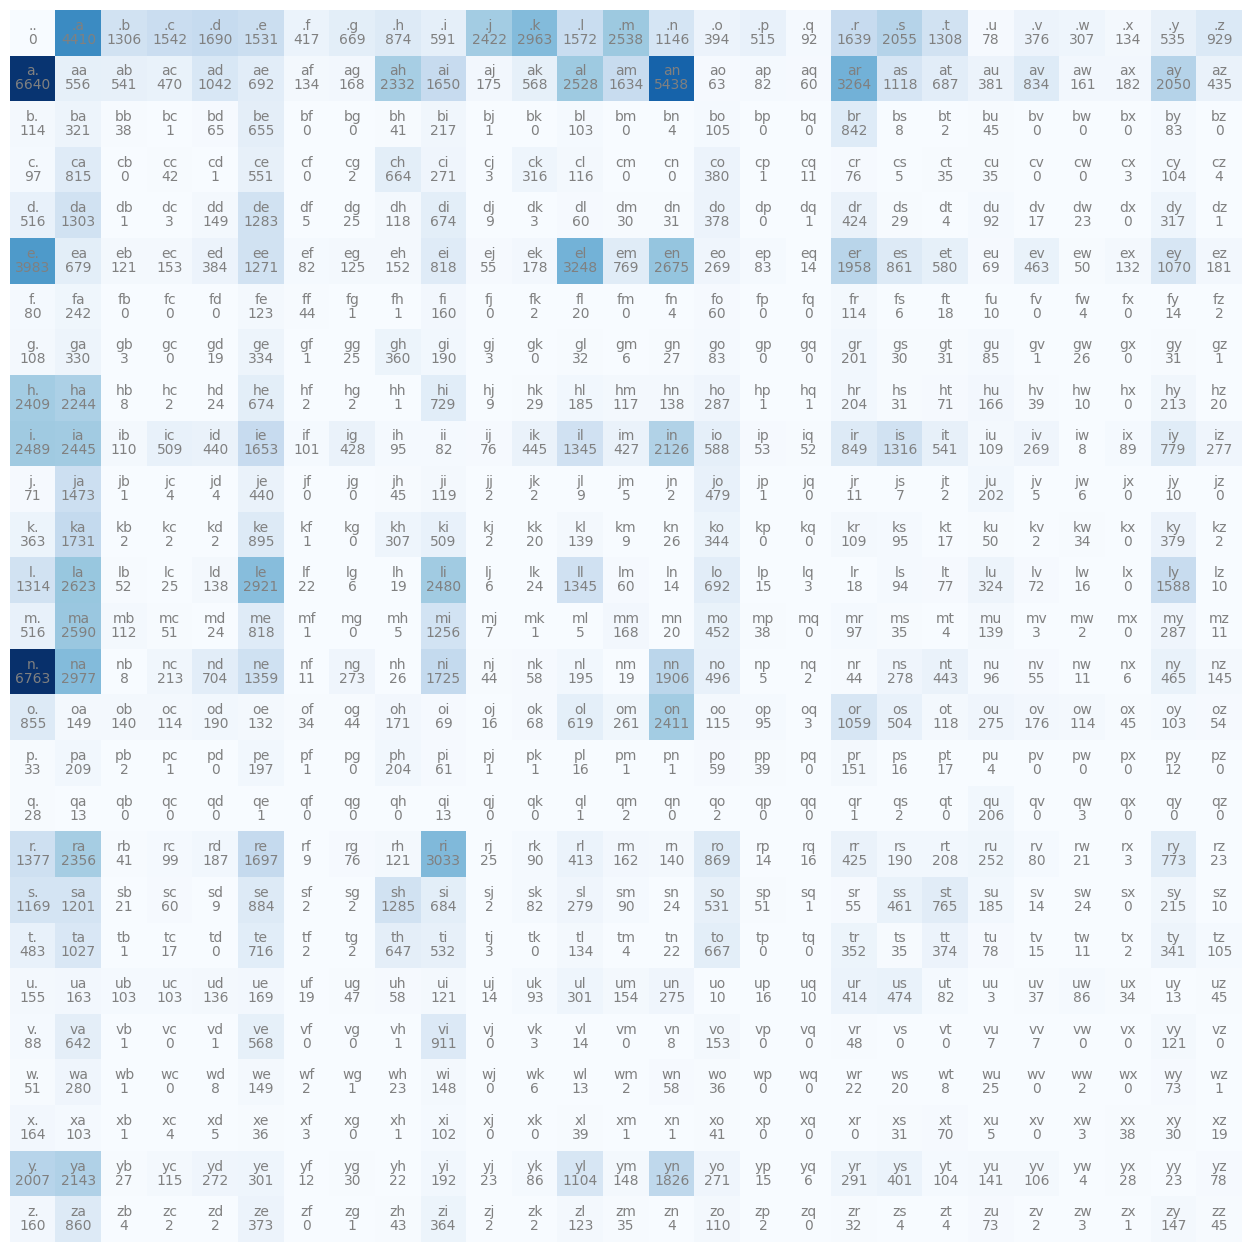

In [13]:
# print the matrix
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j] # character string of bigram, e.g. 'ab'
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray') # upper text: bigram
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray') # lower text: count
plt.axis('off')

**TODO:** 3b) Why do we use `.item()` in the code cell above? Check out the PyTorch documentation if needed! **(1 point)**

In [14]:
# YOUR CODE / ANSWER HERE
# We need .item() because N[3,3] is a tensor, not a number, 
# and matplotlib does not know how to plot tensors
print(N[3,3])
print(type(N[3,3]))
print(N[3,3].item())
print(type(N[3,3].item()))

tensor(42, dtype=torch.int32)
<class 'torch.Tensor'>
42
<class 'int'>


**TODO:** 3c) Assume our first character is an 'f'. Looking at the matrix plot above, which is the most likely next character? **(1 point)**

**ANSWER:** We can see from the 7th row how many occurences of each combination with f were in the data, and the highest number is with 'fa', so the next likely character is 'a'.

Here is a visual summary so far - this is how we can get the most likely next character for input 'e' by plucking out the 6th row:

<img src="bigram1.jpg" width="500">

## 4. Sampling New Characters

Now we want to sample new characters. We start with the first character `.`, 
and then sample the next character based on the count of bigrams.
We have the raw counts stored in the matrix N, but we need to convert them to 
probabilities in order to sample from the distribution.

**TODO:** 4a) Pluck out the first row of the matrix, convert the entries to floats, and normalize them so that the row sums to 1. **(3 points)** 

**HINT:** You can simply cast a PyTorch tensor to float using `.float()`, see for example here: https://www.datascienceweekly.org/tutorials/pytorch-change-tensor-type-cast-a-pytorch-tensor-to-another-type

In [15]:
# YOUR CODE GOES HERE
print(N[0])
p = N[0].float()
p = p / p.sum()
p

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

**TODO:** 4b) How can you interpret this row now? **(1 point)**

**ANSWER:** This contains the probability for any single character to be the first character of a word.

To sample from this distribution, we use `torch.multinomial`, which samples from the multinomial probability distribution (in simple words: "you give me probabilities and I will give you integers sampled according to the probability distribution").

In [16]:
g = torch.Generator().manual_seed(2147483647) # makes the random numbers reproducible
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample from the distribution
# replacement=True means that we are sampling with replacement (i.e. we can sample the same index multiple times)
print("sampled index:", ix) # print the sampled index
itos[ix] # convert the sampled index to a character

sampled index: 10


'j'

**TODO:** 4c) Sample 100 characters according to your probability distribution for word beginnings. Print the sampled indices and characters. Can you relate the output to your probability distribution? Did you expect this output, or can you see unexpected output characters? **(2 points)**

In [17]:
# YOUR CODE GOES HERE
g = torch.Generator().manual_seed(2147483647) # makes the random numbers reproducible
ids = torch.multinomial(p, num_samples=100, replacement=True, generator=g) # sample 100 characters
print('sampled indices:', ids) # print the sampled indices
chars = [itos[ids[i].item()] for i in range(100)]
print('sampled characters:', chars) # print the sampled characters

sampled indices: tensor([13, 19, 14,  1,  1, 20, 20,  1, 13, 13, 13, 11, 23, 13, 19, 18, 26, 11,
         7, 19,  1, 11, 18, 10, 11, 15,  2,  9, 18,  2,  5,  3,  1, 13, 11, 11,
        22, 11, 15, 26,  2, 18, 13, 10,  1, 15,  2,  3, 15, 10, 12,  4,  9,  3,
         4,  6,  4, 19, 10,  3,  8,  4, 10, 13, 14, 13, 10, 19, 11,  8, 13,  5,
         5,  6, 25, 20, 10, 18,  1,  8,  3,  2, 20,  1,  1,  3, 10, 11, 25, 18,
         1,  9, 11,  8, 12,  3, 12, 19,  9, 18])
sampled characters: ['m', 's', 'n', 'a', 'a', 't', 't', 'a', 'm', 'm', 'm', 'k', 'w', 'm', 's', 'r', 'z', 'k', 'g', 's', 'a', 'k', 'r', 'j', 'k', 'o', 'b', 'i', 'r', 'b', 'e', 'c', 'a', 'm', 'k', 'k', 'v', 'k', 'o', 'z', 'b', 'r', 'm', 'j', 'a', 'o', 'b', 'c', 'o', 'j', 'l', 'd', 'i', 'c', 'd', 'f', 'd', 's', 'j', 'c', 'h', 'd', 'j', 'm', 'n', 'm', 'j', 's', 'k', 'h', 'm', 'e', 'e', 'f', 'y', 't', 'j', 'r', 'a', 'h', 'c', 'b', 't', 'a', 'a', 'c', 'j', 'k', 'y', 'r', 'a', 'i', 'k', 'h', 'l', 'c', 'l', 's', 'i', 'r']


**ANSWER:** Some characters should occur very often, e.g. we see an 'a' many times, which fits the probability of 0.1377. Some characters are very rare, so it is a bit surprising to see several 'y' sampled with probability 0.0167.

This is the updated visualization including normalization for probabilities as outputs:

<img src="bigram2.jpg" width="600">

---

## 5. Broadcasting
We store all probabilities in a matrix `P`, so that each row is normalized to 1 and contains the probabilities for the next character:

In [18]:
P = (N+1).float() 
P /= P.sum(1, keepdims=True) # normalize the rows of P (we use keepdims=True to keep the dimensions of P, see below)

**TODO:** 5) Can you think of a reason why we calculate the probabilities based on `N+1` instead of `N`? **(1 point)**

**HINT:** What happens for `N=0`?

**ANSWER:** We add 1 to all counts because we don't want any zero probabilities. Otherwise a combination that was not contained in the training data could never be sampled. This is called **model smoothing**. We can add higher numbers to get more smoothing, until the distribution converges to a uniform distribution where all characters are equally likely.

We need `keepdims=True` in order to sum each line, the result should be a 27x1 column vector containing the row sums - otherwise all entries get collapsed to a 1D instead of 2D array: 

In [19]:
print(P.sum(1, keepdims=True).shape) # shape collapes to 27x1 due to summation along axis 1 (column vector)
print(P.sum(1, keepdims=False).shape) # 1D tensor of size 27

torch.Size([27, 1])
torch.Size([27])


But why does the division above `P /= P.sum(1, keepdims=True)` even work? We divide the 27x27 matrix `P` by a 27x1 vector. This only works because PyTorch automatically applies **broadcasting**, a type of tensor manipulation: From https://pytorch.org/docs/stable/notes/broadcasting.html we get the information that two tensors are **broadcastable** if the following rules hold:

    Each tensor has at least one dimension.

    When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

If two tensors x, y are “broadcastable”, the resulting tensor size is calculated as follows:

    If the number of dimensions of x and y are not equal, prepend 1 to the dimensions of the tensor with fewer dimensions to make them equal length.

    Then, for each dimension size, the resulting dimension size is the max of the sizes of x and y along that dimension.
    
In our case, broadcasting takes the 27x1 column vector and copies it 27 times to get a 27x27 matrix, then it makes an element-wise division. We can check the result:

In [20]:
# check that the first row sums to 1
print(P[0].sum())

tensor(1.)


**TODO (optional):** What happens if you remove `keepdims=True`? Will the division still result in the same matrix - why or why not? 

 **HINT:** Don't forget to revert your changes for later cells to work right - or copy the code cell and use different variable names.


**ANSWER:** The division will work via broadcasting, but will result in a different matrix. In broadcasting, we always align right and add missing dimensions on the left, so the 1D tensor of length 27 becomes a 2D tensor of shape 1x27 - this is a row instead of a column! The row is then copied to 27 rows, which means we normalize over columns instead of rows:

In [21]:
# YOUR CODE GOES HERE
# Compare the two ways of normalizing
P_test = N.float()
sum1 = P_test.sum(1, keepdims=True) # shape 27x1 (2D tensor)
print(sum1.shape)
sum2 = P_test.sum(1) # shape 27 (1D tensor, 2nd dimension is collapsed)
print(sum2.shape)

P1 = P_test/sum1 # 27x27 / 27x1 broadcasted to 27x27:
# 27, 27
# 27,  1
P2 = P_test/sum2 # 27x27 / 27 broadcasted to 1x27, then 27x27 -> sum is copied to each row instead of each column
# 27, 27
#  1, 27 # we align right and then broadcast to the left
(P1==P2).all() # check if the two matrices are equal

torch.Size([27, 1])
torch.Size([27])


tensor(False)

In [22]:
# YOUR CODE GOES HERE
# we are actually normalizing the columns of P, not the rows:
print('row sums:', P1[0].sum(), P2[0].sum())
print('column sums:', P1[:,0].sum(), P2[:,0].sum())

row sums: tensor(1.) tensor(7.0225)
column sums: tensor(3.0222) tensor(1.)


## 6. Generating New Names

With this, we can sample new names by starting with the start character `.` and sampling the next character, then the next next character and so on, until we sample the end character `.`:

In [23]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20): # generate 20 names
  
    out = []
    ix = 0 # start with the start-of-word character
    while True:
        p = P[ix] # get the probabilities of the next character by plucking the row corresponding to the current character
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample the next character (=column index)
        out.append(itos[ix]) # convert the sampled index to a character and append it to the output
        if ix == 0: # if we sampled the end-of-word character: break
            break
    print(''.join(out)) # print the generated name

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


This doesn't look right... but it is! The bigram language model is simply not  powerful enough to create more reasonable names. For example, it generated a name "a" twice, but it doesn't know that "a" is the first character here. All it knows is that "a" is a character in the name and how likely it is that the name ends here, without looking at previous characters.

**TODO:** 6) In the code cell above, experiment with replacing `p` with the uniform distribution, making everything equally likely. Can you see that the bigram model works better than pure chance? **(2 points)**

**HINT:** Don't forget to revert your changes for later cells to work right - or copy the code cell and use different variable names.

In [24]:
# YOUR CODE GOES HERE
g = torch.Generator().manual_seed(2147483647)

for i in range(20): # generate 20 names
  
    out2 = []
    ix = 0 # start with the start-of-word character
    while True:
        #p = P[ix] # get the probabilities of the next character by plucking the row corresponding to the current character
        p2 = torch.ones(27) / 27 # uniform distribution, equal probability for all characters
        ix = torch.multinomial(p2, num_samples=1, replacement=True, generator=g).item() # sample the next character (=column index)
        out2.append(itos[ix]) # convert the sampled index to a character and append it to the output
        if ix == 0: # if we sampled the end-of-word character: break
            break
    print(''.join(out2)) # print the generated name

juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.
rkrrsru.
iyumuyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.
f.
.
ndxjxfpvslqtikyzsaloevgvvnundewkfmbjzqegruxiteaxchwtmurzsodridcdznojvaliypvrghvxtezrwguciqqvywhqelv.
viosvhibdhnceukgmtmwboscnbzoiwupnwnpipixtewbgsgyewfdacbfcxrvjypkmsbranmjrdsydotafvkdkbdepihzpwzsqdab.
vfuolwbasrtugttbiqbujfdtskceqjtcdlcndfujqllsppgkltalmlokdmsl.
fddmxjv.
mfsgxmw.
vdihkvngtojvrdsyqivcob.
uziengogtjvnvqgfjtkqufrxfjlwglykiiluohgnoiuwzylq.
fsgircvmhtipagkxwvjypnsriadmfujnlkcicvatjvryzeljxkbrlrjsp.


## 7. Evaluating the Model

We want to evaluate the quality of the model using a single number, the **training loss**. But which single number to use? Let's print the probabilities of the first bigrams to start with:

In [25]:
for w in words[:3]: # print bigram probabilities for the first 3 words
    chs = ['.'] + list(w) + ['.'] # add start and end of word characters
    for ch1, ch2 in zip(chs, chs[1:]): # iterate over bigrams
        ix1 = stoi[ch1] # get the integer representation of the characters
        ix2 = stoi[ch2] # get the integer representation of the characters
        prob = P[ix1, ix2] # get the probability of the bigram
        print(f'{ch1}{ch2}: {prob:.4f}') # print the bigram and its probability

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a.: 0.1958
.o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a.: 0.1958
.a: 0.1376
av: 0.0246
va: 0.2473
a.: 0.1958


**TODO:** 7a) What probabilities would we expect for an untrained model? How do you interpret these outputs compared to the untrained model? **(2 points)**

**ANSWER:** 
In a uniform distribution (i.e. an untrained model), the probability of each bigram would be 1/27 = 0.0370.
So everything above roughly 4% means that we have learned something from the data. We see that some of the probabilities of our model are quite high, e.g. 39% for `ma`, which means the model is quite good. 
In a very good model, the probabilities would be near 1.0, especially on the training data, because that means that the model is correctly predicting what is going to come next.

So how can we summarize these probabilities in a single number? First of all, we can use the **likelihood**, which is the product of all these probabilities. The likelihood tells us which probability our model assigns to the whole dataset. So we want the likelihood to be as big as possible for a good model (**maximum likelihood estimation**). 

**TODO**: 7b) Can you think of a problem when calculating the likelihood as defined above? **(1 point)**

**HINT**: What happens numerically if we multiply many tiny numbers?

**ANSWER:** Multiplying all of these probabilities between 0 and 1 can lead to a tiny resulting number especially for a large number of output possibilities or if a single output is very unlikely. This may cause numerical instabilities when approaching machine precision. 

Instead of the likelihood, we use the **log likelihood**: Applying the logarithm transforms the likelihood to a value in $[-\infty, 0]$.

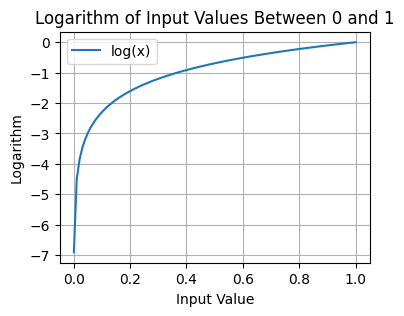

In [26]:
# Generate input values between 0 and 1
x = torch.linspace(0.001, 1, 100)  # Avoid log(0) by starting from 0.001

# Compute the logarithm of the input values
y = torch.log(x)

# Create the plot
plt.figure(figsize=(4, 3))
plt.plot(x, y, label='log(x)')
plt.title('Logarithm of Input Values Between 0 and 1')
plt.xlabel('Input Value')
plt.ylabel('Logarithm')
plt.legend()
plt.grid(True)
plt.show()

**TODO:** 7c) Why is maximizing the likelihood equivalent to maximizing the log likelihood? **(1 point)**

**ANSWER:** Because log is monotonically increasing, so the maximum of the logarithm is at the same position as the maximum input.

Instead of maximizing the log likelihood, in practice we minimize the negative log likelihood, because a loss usually is a number in $[0,\infty]$, where small numbers are good. Finally, the negative log likelihood is simply the sum of the single logarithms due to

$$\log(a*b*c) = \log(a) + \log(b) + \log(c)$$

This is great because a single probability close to zero will not cause the whole loss to be tiny any more, we now use addition instead of multiplication!

**TODO:** 7d) Calculate the **negative log likelihood loss**, store it in `nll` and print it. Sometimes, we also use the **average negative log likelihood loss**, so average `nll` by the number of bigrams evaluated and print the average as well. **(3 points)**

**HINT:** You can start by copying the second last code cell above, where we calculated the probabilities of bigrams. Then apply `torch.log` to these probabilities and sum the negative logarithms.

In [27]:
# YOUR CODE GOES HERE
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["emma"]: # we can also test with a single word. Try it out!
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


This summarizes our first bigram model, which simply counts occurences of bigrams and generates new names based on the corresponding probability distribution. The average log likelihood loss of this model is around 2.45.

The following visualization includes the whole bigram model with negative log likelihood loss:

<img src="bigram3.jpg" width="800">

---

## 8. The Neural Network Approach

Let's try another approach: a neural network! Our neural network will still be a bigram language model: It receives a single character as an input, processes it using some weights or some parameters w and outputs the probability distribution over the next character. We will evaluate the parameters of the neural net using the negative log likelihood loss, which means comparing the output probability distribution and the label (the identity of the next character). We are going to use gradient-based optimization to tune the parameters of this network to minimize the loss with the goal to better predict the next character. In the end, the result will look quite similar to the intuitive approach counting occurances of bigrams above!

First, let's create the training set for the neural network made of two lists, the inputs and the targets: 

In [28]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]: # only use the first word for now, which contains 5 examples
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1) # input is the first character of the bigram
        ys.append(ix2) # target is the second character of the bigram
    
xs = torch.tensor(xs) # convert the list to a tensor
ys = torch.tensor(ys) # convert the list to a tensor

. e
e m
m m
m a
a .


We print the 5 resulting inputs and targets:

In [29]:
xs

tensor([ 0,  5, 13, 13,  1])

In [30]:
ys

tensor([ 5, 13, 13,  1,  0])

**TODO:** 8) The following code cell applies **one-hot-encoding**. Shortly explain what this is and why it is needed! **(2 points)**

**ANSWER:** We cannot directly feed in the indices because the neural net will interpret higher numbers as more important (through multiplication with the weights). Therefore we need **one-hot encoding**: Each index is converted to a vector of zeroes with only a single 1 indicating the class.

In [31]:
# apply one-hot encoding to the input
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
print(xenc)
print(xenc.shape)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 27])


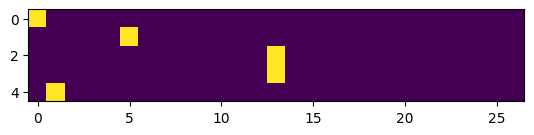

In [32]:
# we can also visualize the one-hot encoding like this:
plt.imshow(xenc)

In [33]:
# check the data type of the one-hot encoding
xenc.dtype

torch.float32

## 9. The First Neuron

A neuron consists of a simple dot product $x\cdot W + b$. We don't use a **bias** $b$ here, so let's first initialize the **weights** $W$ randomly sampled from a normal distribution, i.e., most weights will be around 0:

In [34]:
W = torch.randn((27, 1))
W

tensor([[-0.6276],
        [-1.6219],
        [ 0.3714],
        [-0.3928],
        [-0.3915],
        [-1.1919],
        [ 0.0862],
        [ 0.5267],
        [ 0.5921],
        [ 0.7252],
        [ 0.6823],
        [-1.3971],
        [ 0.5291],
        [-1.7913],
        [ 1.3206],
        [-0.2802],
        [-1.9748],
        [ 0.3579],
        [-0.4658],
        [ 0.3624],
        [ 0.1235],
        [ 1.0322],
        [-0.5447],
        [ 0.9965],
        [ 1.1820],
        [-0.7209],
        [-1.2600]])

**TODO:** 9) Apply the matrix multiplication (denoted by `@` in PyTorch) to get the **logits**. Store the result in a variable called `logits`. Which shape will the result have and why? Check your predicted shape by printing the result! **(2 points)**

In [35]:
# YOUR CODE GOES HERE
logits = xenc @ W # log-counts
print(logits)
print(logits.shape)

tensor([[-0.6276],
        [-1.1919],
        [-1.7913],
        [-1.7913],
        [-1.6219]])
torch.Size([5, 1])


**ANSWER:** The logits have the shape 5x1 because the input 5x27 matrix was multiplied by a 27x1 matrix. This can be interpreted as all 5 examples being evaluated simultaneously, so the neuron's activation is calculated for all 5 examples.

## 10. Creating 27 Neurons

Now we want 27 neurons instead of just one, because we eventually want to output the 27 probabilities for each character to be the next. So we want the weight matrix to be 27x27 instead of 27x1, and we will in parallel evaluate the 5 inputs on 27 neurons, so the output will be 5x27 (matrix multiplication of a 5x27 input with 27x27 weight matrix).

In [36]:
# randomly initialize 27 neurons' weights. Each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)
print(W)

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [-6.7006e-01, -1.2199e+00,  3.0314e-01, -1.0725e+00,  7.2762e-01,
          5.1114e-02,  1.3095e+00, -8.0220e-01, -8.5042e-01, -1.8068e+00,
          1.2523e+00, -1.2256e+00,  1.2165e+00, -9.6478e-01, -2.3211e-01,
         -3.4762e-01,  3.3244e-01, -1.3263e+00,  1.1224e+00,  5.9641e-01,
          4.5846e-01,  5.4011e-02, -1.7400e+00,  1.1560e-01,  8.0319e-01,
          5.4108e-01, -1.1646e+00],
        [ 1.4756e-01, -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01,  1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,
          9.3743e-01, -8.8303e-01,  1.74

In [37]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
print(logits)

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

These numbers tell us the firing rate of each of the 27 neurons on the 5 inputs. For example, the result at row 3 and column 13 is giving us the firing rate of the 13th neuron looking at the third input:

In [38]:
(xenc @ W)[3,13]

tensor(0.0379)

 This is equivalent to a dot product between the third input and the 13th column of $W$, so using matrix multiplication we can very efficiently evaluate the dot product between lots of input examples in a batch and lots of neurons:

In [39]:
(xenc[3] * W[:,13]).sum() # element-wise multiplication and sum is equivalent to matrix multiplication, but less efficient

tensor(0.0379)

Here we can see the steps so far, including one-hot-encoding, weights and logit calculation for input 'e':

<img src="neuron1.jpg" width="500">

Note that in the image we only plot a single input 'e', whereas in the code we process 5 inputs in parallel.

We see that the logits are positive and negative. They can be interpreted as **log counts** (=logarithms of the counts of each bigram). We can elementwise exponentiate to transform them into numbers in $(0, \infty)$, where negative numbers go to $(0,1)$ and positive numbers go to $(1,\infty)$:

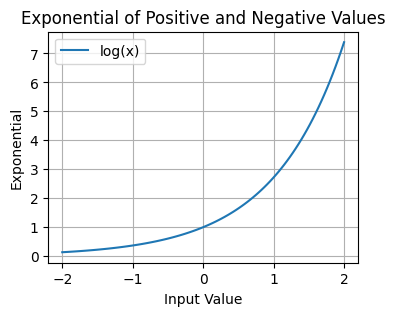

In [41]:
# Generate input values between -2 and 2
x = torch.linspace(-2, 2, 100)  # 

# Compute the exponential of the input values
y = torch.exp(x)

# Create the plot
plt.figure(figsize=(4, 3))
plt.plot(x, y, label='log(x)')
plt.title('Exponential of Positive and Negative Values')
plt.xlabel('Input Value')
plt.ylabel('Exponential')
plt.legend()
plt.grid(True)

**TODO:** 10a) Calculate the counts from the log counts by applying exponential function. Store the result in `counts` and print it. Normalize the counts like above, store the result in `probs` and print it. **(2 points)** 

In [42]:
# YOUR CODE GOES HERE
counts = logits.exp() # counts, comparable to N (where each row was the count of a bigram)
print(counts)
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character (like P above)
print(probs)

tensor([[ 4.7940,  0.7888,  0.9730,  0.3326,  1.3309,  0.9708,  0.2129,  1.8311,
          1.0824,  2.4710,  0.6242,  2.1964,  0.7200,  0.6486,  3.9469, 18.7908,
          4.7673,  0.1967,  1.9683,  0.4315,  2.6775,  0.8621,  0.2277,  1.5656,
          0.9317, 12.1434, 11.5281],
        [ 1.6038,  4.4060,  1.3737,  2.8830, 11.0032,  1.5972,  0.5187,  1.8527,
          0.5369,  1.6654,  3.8818,  1.2642,  0.6339,  0.9987,  0.5995,  1.7432,
          1.6073,  0.2499,  5.0680,  1.1876,  2.6871,  1.6596,  2.7728,  0.1486,
          0.6521,  0.1193,  2.6128],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373,
          2.2763,  0.4719,  2.5289,  0.2265,  0.8082,  0.3054,  0.5164,  0.7918,
          4.6866,  1.8232,  0.4921],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373

Here are the visualized steps including exponentiation and normalization:

<img src="neuron2.jpg" width="700">

**TODO:** 10b) Do the last two maths operations in the cell above look familiar? How is this transformation called? **(1 point)**

**ANSWER:** It is a **Softmax** function: 

$$Softmax(z)_j = \frac{\exp(z_j)}{\sum_{j=1}^K\exp(z_j)}$$

Let's take a look at the resulting "probabilities" for the first character (of course they are meaningless because the network is still untrained, the weights are randomly initialized):

In [43]:
probs[0]

tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])

In [44]:
probs[0].shape

torch.Size([27])

In [45]:
probs.shape

torch.Size([5, 27])

## 11. Summary (so far)

Let's summarize the code so far to get an overview of the steps:

In [46]:
xs # input to the network ('.emma')

tensor([ 0,  5, 13, 13,  1])

In [47]:
ys # target for the network ('emma.')

tensor([ 5, 13, 13,  1,  0])

In [48]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [49]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

In [50]:
probs.shape # output probabilities of shape 5x27

torch.Size([5, 27])

In [51]:
# compute the negative log likelihood loss for the first 5 bigrams
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indices {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indices 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indices 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

Here is a visualization of the first feedforward pass of input 'e' through the neuron, including negative log likelihood loss calculation. You can see in the output above that the loss is roughly 4 (see 'bigram example 2' output).

<img src="neuron3.jpg" width="900">

We see from the output above that the average loss is 3.7, which is quite high. We can change the random seed for sampling $W$ for randomly changing the loss. But of course, we can do better: The loss calculation is only made up of differentiable operations (multiplication, addition, exponential, division...) We can minimize the loss by computing the gradients of the loss with respect to $W$. 

## 12. Optimization

To calculate the loss, we basically need to pluck out the predicted 
probabilities at the indices of the target characters. For example, for the first bigram,
the input character is '.' (index 0) and the target character is 'e' (index 5), and the predicted probability is stored in `probs[0,5]`.

In [52]:
# we need the following probabilities for calculating the loss:
probs[0,5], probs[1,13], probs[2,13], probs[3,1], probs[4,0] 

(tensor(0.0123),
 tensor(0.0181),
 tensor(0.0267),
 tensor(0.0737),
 tensor(0.0150))

This is equivalent to:

In [53]:
probs[torch.arange(5), ys]

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150])

We can use this in the loss calculation at the end of the forward pass:

In [54]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # we need to compute gradients

In [55]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean() # average negative log likelihood loss

In [56]:
print(loss.item()) # print the loss

3.7693049907684326


Note that the loss is the same as above. Finally we can do the backward pass:

In [57]:
# backward pass
W.grad = None # set to zero the gradient (None is a special value that PyTorch recognizes as "set to zero")
loss.backward() # compute the gradients

Something magical happened when `loss.backward()` was run: PyTorch keeps track of all the operations in the forward pass, under the hood it builds a full computational graph, so it knows all the dependencies and all the mathematical operations inside the neural network. When we calculate the loss and call a `.backward()` on it, PyTorch fills in the partial derivatives of all the intermediate steps. So now we can look at the gradient and see that it is not zero anymore:

In [58]:
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [59]:
W.shape, W.grad.shape

(torch.Size([27, 27]), torch.Size([27, 27]))

Both `W` and `W.grad` are of shape 27x27, and each entry of `W.grad` is telling us the influence of that weight on the loss function. For example, since `W.grad[0,0]` is positive, slightly increasing `W[0,0]` will lead to a slightly bigger loss. Therefore we use the *negative* gradient for updating the weights:

In [60]:
W.data += -0.1 * W.grad # update the weights with learning rate 0.1

Let's check that the loss has really decreased using this one **gradient descent** step:

In [61]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()
print(loss.item())

3.7492127418518066


## 13. Optimizing over the Whole Dataset

Now let's apply gradient descent to the whole dataset:

In [62]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement() # number of elements in the tensor xs (5 in '.emma.', here more)
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [63]:
# gradient descent
for k in range(500):
  
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts - one-hot input will pluck the correct row from W, like in the previous bigram model
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())
    
    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    
    # update
    W.data += -50 * W.grad # even a large learning rate is fine here, because the bigram model is very simple

3.7686190605163574
3.3788068294525146


3.161090850830078
3.027186155319214
2.9344842433929443
2.8672313690185547
2.816654682159424
2.777146577835083
2.745253801345825
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633665084838867
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.582256317138672
2.5764293670654297
2.5711238384246826
2.566272735595703
2.5618226528167725
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243709087371826
2.522773265838623
2.521263837814331
2.519836664199829
2.5184857845306396
2.5172057151794434
2.515990734100342
2.5148372650146484
2.5137410163879395
2.512697696685791
2.511704444885254
2.5107581615448
2.509855031967163
2.5089924335479736
2.5081686973571777
2.507380485534668
2.5066256523132324
2.5059030055999756
2

We see that the loss is converging roughly to 2.48, which is similar to the loss we achieved all the way up in the original bigram model without a neural network (2.45). Back then, we achieved this loss by counting, now by optimizing weights. That makes sense because fundamentally we're not using any additional information, we're still just taking in the previous character and trying to predict the next one, but instead of doing it explicitly by counting and normalizing we are doing it with gradient-based learning. The explicit approach happens to very well optimize the loss function without any need for a gradient based optimization because the setup for bigram language models is so straightforward, we can just afford to estimate those probabilities directly and maintain them in a table. But the gradient-based approach is significantly more flexible, so we've actually gained a lot because we can expand this approach and complexify the neural net.

**TODO (optional):** Remember the model smoothing used in the first bigram model by adding a number to the counts to avoid zero probabilities. Can you think of a smoothing equivalent in gradient descent based bigram model?

**HINT:** Think of the weight matrix $W$ and its influence on the result!

**ANSWER:** If all weights are initialized to 0, exponentiating will result in uniform counts of 1, so each character is equally likely (uniform distribution). Initializing all weights close to 0 is therefore a form of model smoothing. This leads us to **Regularization:** We can actually augment the loss function and add a punishment term (e.g. consisting of the sum of squared weights) so that large weights will increase the loss.

Let's see how the weights and the probabilities have changed after training:

In [64]:
print(W)

tensor([[-3.2895e+00,  1.9656e+00,  7.4837e-01,  9.1425e-01,  1.0058e+00,
          9.0709e-01, -3.8237e-01,  8.2961e-02,  3.4820e-01, -3.9621e-02,
          1.3657e+00,  1.5675e+00,  9.3350e-01,  1.4125e+00,  6.1800e-01,
         -4.3777e-01, -1.7532e-01, -1.7782e+00,  9.7520e-01,  1.2013e+00,
          7.4990e-01, -1.9133e+00, -4.8333e-01, -6.7977e-01, -1.4532e+00,
         -1.3781e-01,  4.0890e-01],
        [ 2.2965e+00, -1.8025e-01, -2.0725e-01, -3.4589e-01,  4.4363e-01,
          3.6399e-02, -1.5385e+00, -1.3327e+00,  1.2488e+00,  9.0269e-01,
         -1.2949e+00, -1.5915e-01,  1.3296e+00,  8.9294e-01,  2.0966e+00,
         -2.1706e+00, -1.9615e+00, -2.2076e+00,  1.5854e+00,  5.1385e-01,
          2.9205e-02, -5.5165e-01,  2.2184e-01, -1.3719e+00, -1.2585e+00,
          1.1198e+00, -4.2190e-01],
        [ 1.3027e+00,  2.3723e+00,  2.0947e-01, -1.0908e+00,  7.2807e-01,
          3.1045e+00, -1.1616e+00, -1.1911e+00,  2.6474e-01,  1.9679e+00,
         -1.0697e+00, -1.2726e+00,  1.19

In [65]:
# compute the negative log likelihood loss for the first 5 bigrams
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indices {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indices 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0007, 0.1373, 0.0407, 0.0480, 0.0526, 0.0476, 0.0131, 0.0209, 0.0272,
        0.0185, 0.0754, 0.0922, 0.0489, 0.0790, 0.0357, 0.0124, 0.0161, 0.0032,
        0.0510, 0.0639, 0.0407, 0.0028, 0.0119, 0.0097, 0.0045, 0.0168, 0.0290],
       grad_fn=<SelectBackward0>)
label (actual next character): 5
probability assigned by the net to the the correct character: 0.04764774069190025
log likelihood: -3.0439200401306152
negative log likelihood: 3.0439200401306152
--------
bigram example 2: em (indices 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.1943, 0.0330, 0.0062, 0.0077, 0.0188, 0.0618, 0.0044, 0.0064, 0.0077,
        0.0398, 0.0032, 0.0089, 0.1583, 0.0374, 0.1303, 0.0132, 0.0045, 0.0014,
        0.0953, 0.0419, 0.0282, 0.0038, 0.0226, 0.0030, 0.0067, 0.0520, 0.0090],
       grad_fn=<SelectBackward0>)
label (actual next character

**TODO:** 13) Here is the final visualization after training. Can you interpret the weights, have they improved? Can you compare the trained weights to the weights from our first approach using simple counting instead of a neuron? **(2 points)** 


<img src="neuron4.jpg" width="900">


**ANSWER:** The weights make much more sense now. For example, it is very likely that after 'e' the name ends, but also 'm' for 'emma' is more likely than before, whereas a 'z' is not likely to follow. Interestingly (or naturally), we have learned exactly the same weights as with counting - compare with the final word counting plot above!

## 14. Sampling from the Neural Net

In [66]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  
    out = []
    ix = 0
    while True:
        
        # ----------
        # BEFORE:
        #p = P[ix] # bigram probabilities by counting
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, comparable to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cfay.
a.
nn.
kohin.
tolian.
juwe.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


We get nearly identical samples as in the first model!

## 15. Conclusion

To summarize, we introduced the bigram character level language model, we saw how we can train the model, how we can sample from the model and how we can evaluate the quality of the model using the negative log likelihood loss. We trained the model in two completely different ways that actually get the same result and the same model: First, we just counted the frequency of all the bigrams and normalized. Second, we used the negative log likelihood loss as a guide to optimizing the counts matrix so that the loss was minimized in a gradient-based framework. Both approaches gave the same result, but the gradient-based framework is much more flexible and we can extend it to more complex settings.

In [ ]:
# This cell truncates long output to a maximum length, then converts the notebook to a PDF for submission
# NOTE: You may have to adapt the path or filename to match your local setup

import sys
import os

# Add the parent directory to the sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

# truncate long cell output to avoid large pdf files
from helpers.truncate_output import truncate_long_notebook_output
truncated = truncate_long_notebook_output('1_Bigram_Language_Model__solution.ipynb')

# convert to pdf with nbconvert
if truncated:
    !jupyter nbconvert --to webpdf --allow-chromium-download TRUNCATED_1_Bigram_Language_Model__solution.ipynb
else:
    !jupyter nbconvert --to webpdf --allow-chromium-download 1_Bigram_Language_Model__solution.ipynb

Output in 1_Bigram_Language_Model__solution.ipynb above threshold seen and so a NEW version has been made: `TRUNCATED_1_Bigram_Language_Model__solution.ipynb`.


[NbConvertApp] Converting notebook TRUNCATED_1_Bigram_Language_Model__solution.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 616386 bytes to TRUNCATED_1_Bigram_Language_Model__solution.pdf
